# Preprocess data and add prior GRN information using a human hindbrain dataset

In this notebook, we demonstrate the preprocessing steps and adding prior gene regulatory network (GRN) information needed before running the RegVelo pipeline. The dataset used in this tutorial is a subset of the first-trimester developing human brain dataset collected in [Braun, E. et al, 2023](https://www.science.org/doi/10.1126/science.adf1226).

A detailed description of the preprocessing steps is provided in the [RegVelo manuscript](https://doi.org/10.1101/2024.12.11.627935).

## Library import

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd

import scvelo as scv
import scvi

import regvelo as rgv

## General settings

In [2]:
scvi.settings.seed = 0

[rank: 0] Seed set to 0


In [3]:
scv.settings.set_figure_params("scvelo", dpi=80, transparent=True, fontsize=14, color_map="viridis")

In [4]:
%matplotlib inline

## Load data

In the following, we load the embryonic hindbrain dataset, that has already been preprocessed (see [RegVelo manuscript](https://doi.org/10.1101/2024.12.11.627935)). We further load the GRN learned from the human embryonic hindbrain single-cell multi-ome dataset (see [RegVelo manuscript](https://doi.org/10.1101/2024.12.11.627935)).

In [5]:
adata = rgv.datasets.hindbrain(data_type = "original")

In [6]:
adata

AnnData object with n_obs × n_vars = 49469 × 30958
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'assignment', 'scDblFinder_DropletType', 'scDblFinder_Score', 'scrublet_DropletType', 'Tissue', 'batch', 'Experiment', 'Type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'scrublet_score', 'scrublet_cluster_score_sample', 'scrublet_bh_pval_sample', 'background_fraction_cluster_score_sample', 'background_fraction_bh_pval_sample', 'paper_code', 'method', 'method2', 'FACS', 'stage', 'pcw_cont', 'bulk_name', '10X_run', 'n_genes', 'S_score', 'G2M_score', 'phase', 'leiden_res1', 'leiden_res1_R', 'Celltypist_DHB_predicted_labels', 'Celltypist_DHB_over_clustering', 'Celltypist_DHB_majority_voting', 'Ce

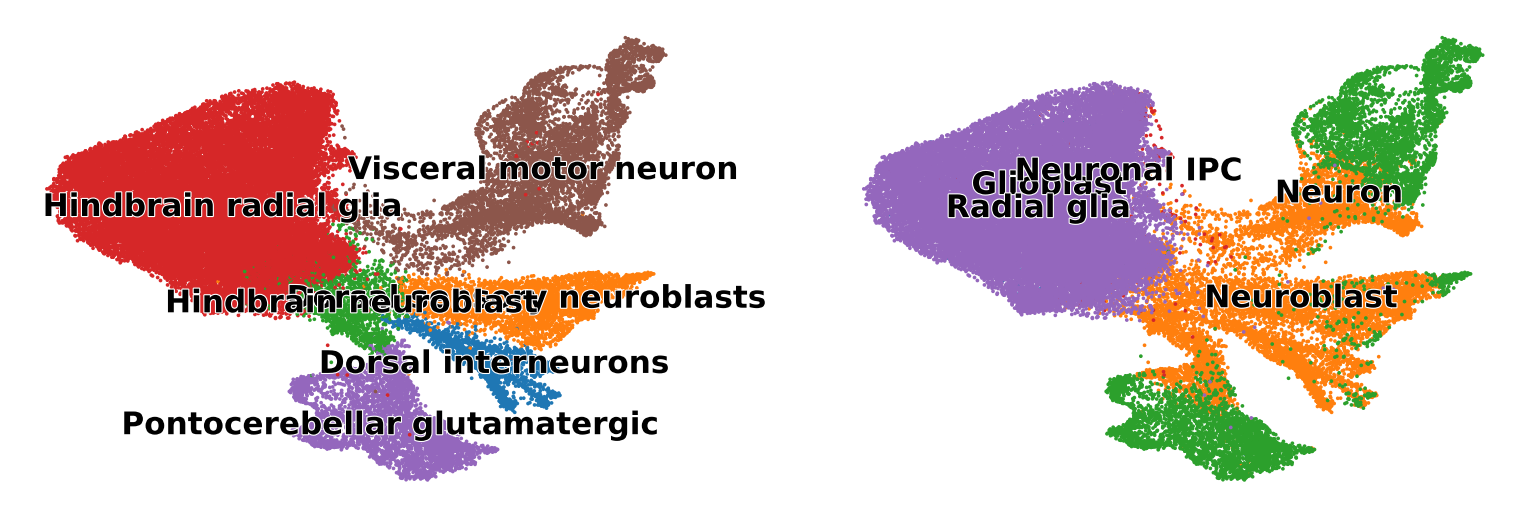

In [7]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=50, use_rep="X_scVI")
sc.tl.umap(adata)
scv.pl.scatter(adata, basis="umap", title="", color=["regvelo_annotation", "CellClass"], legend_loc="on data")

In [8]:
eGRN = pd.read_csv("/lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/brain_analysis/hindbrain/eRegulon_direct.tsv",sep="\t")

## Create prior GRN for RegVelo
In the following, we preprocess the loaded GRN that will be needed as prior GRN for the RegVelo pipeline.

In [9]:
eGRN = eGRN.loc[:,["TF","Gene"]].copy()
reg = pd.crosstab(eGRN['TF'], eGRN['Gene'])

TF = np.unique(reg.index.tolist())
genes = np.unique(TF.tolist() + reg.columns.tolist())

GRN = pd.DataFrame(0, index=genes, columns=genes)
GRN.loc[TF,reg.columns.tolist()] = np.array(reg)

mask = (GRN.sum(0) != 0) | (GRN.sum(1) != 0)
GRN = GRN.loc[mask,mask].copy()

print("Done! processed GRN with " + str(reg.shape[0]) + " TFs and " + str(reg.shape[1]) + " targets")

Done! processed GRN with 151 TFs and 4219 targets


## Preprocess data and align prior GRN for RegVelo pipeline
We perform preprocessing steps, consisting of filtering and normalization. We further compute the first and second order moments (means and uncentered variances) using `scv.pp.moments` needed for velocity estimation. Note that this step might be time-consuming.

:::{note} If preprocessing steps have already performed, you can skip this section and proceed directly to loading prior GRN.

In [10]:
scv.pp.filter_genes(adata, min_shared_counts=20)
scv.pp.normalize_per_cell(adata)
scv.pp.filter_genes_dispersion(adata, n_top_genes=3000)

scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Filtered out 19200 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 3000 highly variable genes.
computing moments based on connectivities
    finished (0:00:06) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [11]:
adata

AnnData object with n_obs × n_vars = 49469 × 3000
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'assignment', 'scDblFinder_DropletType', 'scDblFinder_Score', 'scrublet_DropletType', 'Tissue', 'batch', 'Experiment', 'Type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'scrublet_score', 'scrublet_cluster_score_sample', 'scrublet_bh_pval_sample', 'background_fraction_cluster_score_sample', 'background_fraction_bh_pval_sample', 'paper_code', 'method', 'method2', 'FACS', 'stage', 'pcw_cont', 'bulk_name', '10X_run', 'n_genes', 'S_score', 'G2M_score', 'phase', 'leiden_res1', 'leiden_res1_R', 'Celltypist_DHB_predicted_labels', 'Celltypist_DHB_over_clustering', 'Celltypist_DHB_majority_voting', 'Cel

:::{note} The function rgv.pp.set_prior_grn aligns the loaded GRN with the gene expression data in adata and by default, it removes genes without incoming or outgoing regulatory edges.

In [12]:
adata = rgv.pp.set_prior_grn(adata, GRN.T)
adata

AnnData object with n_obs × n_vars = 49469 × 1273
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'assignment', 'scDblFinder_DropletType', 'scDblFinder_Score', 'scrublet_DropletType', 'Tissue', 'batch', 'Experiment', 'Type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'scrublet_score', 'scrublet_cluster_score_sample', 'scrublet_bh_pval_sample', 'background_fraction_cluster_score_sample', 'background_fraction_bh_pval_sample', 'paper_code', 'method', 'method2', 'FACS', 'stage', 'pcw_cont', 'bulk_name', '10X_run', 'n_genes', 'S_score', 'G2M_score', 'phase', 'leiden_res1', 'leiden_res1_R', 'Celltypist_DHB_predicted_labels', 'Celltypist_DHB_over_clustering', 'Celltypist_DHB_majority_voting', 'Cel

:::{note} The following steps ensure that only velocity-informative genes and TF genes are considered and updates `adata.uns["skeleton"]` accordingly. The selection of velocity-informative genes is done using `rgv.pp.preprocess_data`, which in addition to min-max scaling of the spliced and unspliced layers, filters genes with non-negative fitted degradation rates $\gamma$ and non-negative $R^2$ values from `scv.tl.velocity` with `mode=deterministic`. The function `rgv.pp.filter_genes` further refines the GRN, such that each gene has at least one regulator. This step further reduces the number of genes considered.

In [13]:
velocity_genes = rgv.pp.preprocess_data(adata.copy()).var_names.tolist()

# select TFs that regulate at least one gene
TF = adata.var_names[adata.uns["skeleton"].sum(1) != 0]
var_mask = np.union1d(TF, velocity_genes)

adata = adata[:, var_mask].copy()

adata = rgv.pp.filter_genes(adata)
adata = rgv.pp.preprocess_data(adata, filter_on_r2=False)

adata.var["velocity_genes"] = adata.var_names.isin(velocity_genes)
adata.var["TF"] = adata.var_names.isin(TF)

adata

computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Number of genes: 684
Number of genes: 628
Number of genes: 623


AnnData object with n_obs × n_vars = 49469 × 623
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'assignment', 'scDblFinder_DropletType', 'scDblFinder_Score', 'scrublet_DropletType', 'Tissue', 'batch', 'Experiment', 'Type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'scrublet_score', 'scrublet_cluster_score_sample', 'scrublet_bh_pval_sample', 'background_fraction_cluster_score_sample', 'background_fraction_bh_pval_sample', 'paper_code', 'method', 'method2', 'FACS', 'stage', 'pcw_cont', 'bulk_name', '10X_run', 'n_genes', 'S_score', 'G2M_score', 'phase', 'leiden_res1', 'leiden_res1_R', 'Celltypist_DHB_predicted_labels', 'Celltypist_DHB_over_clustering', 'Celltypist_DHB_majority_voting', 'Cell

The data is now preprocessed and we can proceed to comparing different RegVelo model setups in the next tutorial!

:::{note} The preprocessed data can also be directly accessed via `rgv.datasets.hindbrain(data_type = "preprocessed")`.